SLaM (Source, Light and Mass): Light Parametric + Mass Total + Source Parametric
================================================================================

SLaM pipelines break the analysis down into multiple pipelines which focus on modeling a specific aspect of the strong
lens, first the Source, then the (lens) Light and finally the Mass. Each of these pipelines has it own inputs which
which customize the model and analysis in that pipeline.

The models fitted in earlier pipelines determine the model used in later pipelines. For example, if the SOURCE PIPELINE
uses a parametric `EllSersic` profile for the bulge, this will be used in the subsequent MASS LIGHT DARK PIPELINE.

Using a SOURCE PARAMETRIC PIPELINE, LIGHT PIPELINE and a MASS LIGHT DARK PIPELINE this SLaM script fits `Imaging` of
a strong lens system, where in the final model:

 - The lens galaxy's light is a bulge `EllSersic`.
 - The lens galaxy's stellar mass distribution is a bulge tied to the light model above.
 - The lens galaxy's dark matter mass distribution is modeled as a `EllNFWMCRLudlow`.
 - The source galaxy's light is a parametric `EllSersic`.

This runner uses the SLaM pipelines:

 `source_parametric/source_parametric__with_lens_light`
 `light_parametric/with_lens_light`
 `mass_total/mass_light_dark`

Check them out for a detailed description of the analysis!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import os
import sys
from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

sys.path.insert(0, os.getcwd())
import slam

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset__ 

Load the `Imaging` data, define the `Mask2D` and plot them.

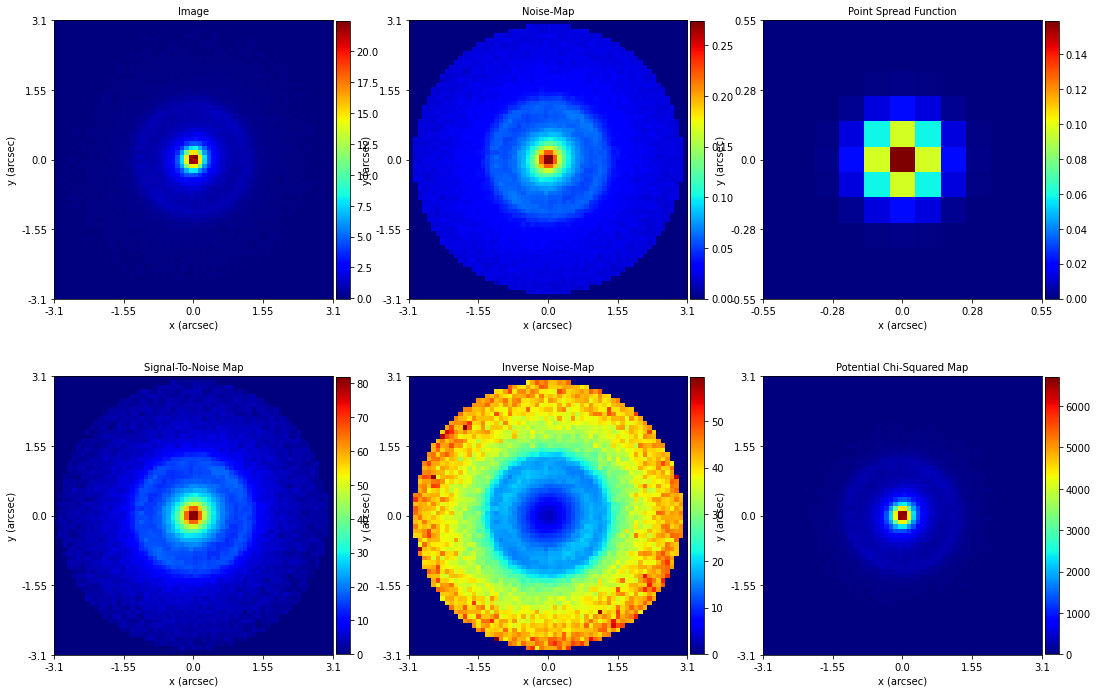

In [2]:
dataset_name = "light_sersic__mass_mlr_nfw__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "slam", dataset_name)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__HYPER SETUP__

The `SetupHyper` determines which hyper-mode features are used during the model-fit.

In [5]:
setup_hyper = al.SetupHyper(
    hyper_galaxies_lens=False,
    hyper_galaxies_source=False,
    hyper_image_sky=None,
    hyper_background_noise=None,
)

__SOURCE PARAMETRIC PIPELINE (with lens light)__

The SOURCE PARAMETRIC PIPELINE (with lens light) uses three searches to initialize a robust model for the 
source galaxy's light, which in this example:

 - Uses a parametric `EllSersic` bulge.

 - Uses an `EllIsothermal` model for the lens's total mass distribution with an `ExternalShear`.

 __Settings__:

 - Mass Centre: Fix the mass profile centre to (0.0, 0.0) (this assumption will be relaxed in the MASS LIGHT DARK 
 PIPELINE).

In [6]:
analysis = al.AnalysisImaging(dataset=imaging)

bulge = af.Model(al.lp.EllSersic)
bulge.centre = (0.0, 0.0)

source_parametric_results = slam.source_parametric.with_lens_light(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    lens_bulge=bulge,
    lens_disk=None,
    mass=af.Model(al.mp.EllIsothermal),
    shear=af.Model(al.mp.ExternalShear),
    source_bulge=af.Model(al.lp.EllSersic),
    mass_centre=(0.0, 0.0),
    redshift_lens=redshift_lens,
    redshift_source=redshift_source,
)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.97it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf < -3842.373 <    inf | logz: -3847.424 +/-    nan | dlogz:  1.099 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 113.39it/s, +200 | bound: 0 | nc: 1 | ncall: 202 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.209]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, 

__LIGHT PARAMETRIC PIPELINE__

The LIGHT PARAMETRIC PIPELINE uses one search to fit a complex lens light model to a high level of accuracy, using the
lens mass model and source light model fixed to the maximum log likelihood result of the SOURCE PARAMETRIC PIPELINE.
In this example it:

 - Uses a parametric `EllSersic` bulge [Do not use the results of the SOURCE PARAMETRIC PIPELINE to initialize priors].

 - Uses an `EllIsothermal` model for the lens's total mass distribution [fixed from SOURCE PARAMETRIC PIPELINE].

 - Uses the `EllSersic` model representing a bulge for the source's light [fixed from SOURCE PARAMETRIC PIPELINE].

 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PIPELINE through to the MASS 
 PIPELINE [fixed values].

In [7]:
bulge = af.Model(al.lp.EllSersic)

light_results = slam.light_parametric.with_lens_light(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_parametric_results,
    lens_bulge=bulge,
    lens_disk=None,
)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 128.68it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__MASS LIGHT DARK PIPELINE (with lens light)__

The MASS LIGHT DARK PIPELINE (with lens light) uses one search to fits a complex lens mass model to a high level of 
accuracy, using the source model of the SOURCE PIPELINE and the lens light model of the LIGHT PARAMETRIC PIPELINE to 
initialize the model priors . In this example it:

 - Uses a parametric `EllSersic` bulge for the lens galaxy's light and its stellar mass [12 parameters: fixed from 
 LIGHT PARAMETRIC PIPELINE].

 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` whose centre is aligned with bulge of 
 the light and stellar mass mdoel above [5 parameters].

 - Uses the `EllSersic` model representing a bulge for the source's light [priors initialized from SOURCE 
 PARAMETRIC PIPELINE].

 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PARAMETRIC PIPELINE through to the MASS 
 LIGHT DARK PIPELINE.

In [8]:
analysis = al.AnalysisImaging(dataset=imaging)

lens_bulge = af.Model(al.lmp.EllSersic)
dark = af.Model(al.mp.EllNFWMCRLudlow)

dark.centre = lens_bulge.centre

mass_results = slam.mass_light_dark.with_lens_light(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_parametric_results,
    light_results=light_results,
    lens_bulge=lens_bulge,
    lens_disk=None,
    lens_envelope=None,
    dark=dark,
)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 16.94it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf < -4197.801 <    inf | logz: -4203.129 +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.